In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2021/trabajo-final/


# Ejercicio 2.2: Face Recognition

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar una solucion para reconocimiento de facial. Se proveen datos de entrenamiento y es necesario entrenar un clasificador para hacer el reconocimiento. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



In [1]:
import cv2 
import numpy as np
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
import sys
import scipy.io



### Cargar Datos de Entrenamiento y Validación


In [2]:
data_dir='./data'
face_recognition_dir = os.path.join(data_dir, 'face_recognition')
training_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_tr.mat')
validation_data_file = os.path.join(face_recognition_dir, 'face_recognition_data_va.mat')

In [3]:
training_data_mat = scipy.io.loadmat(training_data_file)
validation_data_mat = scipy.io.loadmat(validation_data_file)

In [4]:
training_data=training_data_mat['tr_img_sample']
validation_data = validation_data_mat['va_img_sample']

### Esqueleto de funciones para extracción de Features

In [20]:
from enum import Enum

class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, img):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(img)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(img)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(img)	
	
	return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
	resized_image = cv2.resize(img,resize_size)
	image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
	return image_representation
  
def extract_lbp_features(img):
  return []

def extract_hog_features(img):
  return []


   

### Armar los datos de entrenamiento y sus etiquetas

In [5]:
training_images = []
training_labels = []
for training_image in training_data:
    image = (training_image[0]/255)
    label = training_image[2]
    training_images.append(image.reshape(64*64))
    training_labels.append(label.reshape(1))

training_images = np.asarray(training_images)
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape(training_labels.shape[0])

In [6]:
training_labels.shape

(368,)

### Construir datos de validación y sus etiquetas


In [7]:
validation_images = []
validation_labels = []
validation_names = []
for validation_image in validation_data:
    image = (validation_image[0]/255)
    label = validation_image[2] 
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image.reshape(64*64))
    validation_labels.append(label.reshape(1))
    validation_names.append(name)

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])

In [24]:
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,algorithm='brute')
knn_classifier.fit(training_images,training_labels)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

#### Guardar Modelo Entrenado

In [8]:
pickle.dump(knn_classifier,open('./face_recogition', 'wb'))

NameError: name 'knn_classifier' is not defined

#### Cargar modelo

In [26]:
classifier = pickle.load(open('./face_recogition','rb'))

### Clasificar los datos de validación


In [27]:
labels = classifier.predict(validation_images)
## Get score for each sliding window patch
scores = classifier.predict_proba(validation_images)

###  Evaluar modelo de Reconocimento

In [28]:
acc = np.mean(labels==validation_labels)*100

In [29]:
print('The accuracy of face recognition is:%.2f \n' % acc)


The accuracy of face recognition is:16.22 



### Visualize Recognition ###

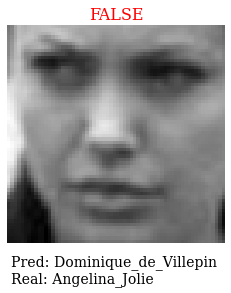

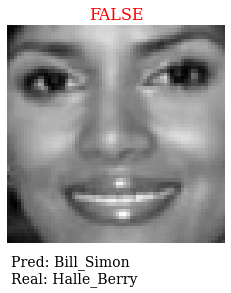

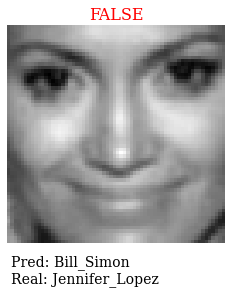

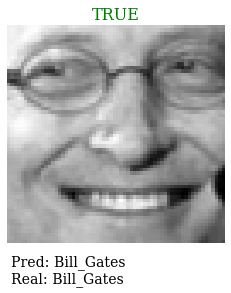

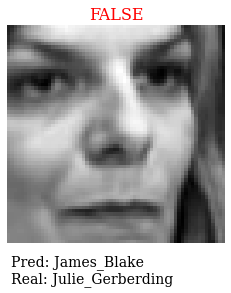

In [30]:
indexes = [13,50,77,18,110] # You can use Random Sample
for index in indexes:
    predicted_label=labels[index]
    real_label = validation_labels[index]

    pred_name = validation_names[np.nonzero(validation_labels==predicted_label)[0][0]]
    real_name = validation_names[np.nonzero(validation_labels==real_label)[0][0]]
    if real_label==predicted_label:
        text='TRUE'
        color='g'
    else:
        text='FALSE'
        color='r'
    font = {'family': 'serif',
            'color':  color,
            'weight': 'normal',
            'size': 16,
            }    
    plt.imshow(validation_images[index].reshape(64,64), cmap='gray')
    plt.axis('off')
    plt.title(text, fontdict=font)
    sub_font = {'family': 'serif',
            'weight': 'normal',
            'size': 14,
            }    
    plt.text(0.5, 75, 'Pred: {} \nReal: {}'.format(pred_name[:-5],real_name[:-5]), fontdict=sub_font)

    plt.show()


In [ ]:
#RESOLUCION DEL EJERCICIO

In [9]:
#Imports
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import *
import sys
import math
from image_utils import *
from skimage.feature import local_binary_pattern, hog
from sklearn.svm import SVC

In [10]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3

def extract_features(method, img):
    '''Switch between Feature extraction Methods'''

    image_representation = []

    if method == FeatureExtractors.MiniImage:
        image_representation = extract_mini_image_features(img)
    elif method == FeatureExtractors.HOG:
        image_representation = extract_hog_features(img)
    elif method == FeatureExtractors.LBP:
        image_representation = extract_lbp_features(img)

    return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
    resized_image = cv2.resize(img,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation


def extract_lbp_features(img, radius=3, method='uniform'):
    #https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py
    n_points = 8 * radius
    return local_binary_pattern(img, P=n_points, R=radius, method=method)
    

def extract_hog_features(img,orientations=8,pixels_per_cell=(16, 16),cells_per_block=(1, 1)):
    #https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
    return hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)

In [11]:
training_images = []
training_labels = []
for training_image in training_data:
    image = (training_image[0]/255)
    label = training_image[2]
    training_images.append(image.reshape(64*64))
    training_labels.append(label.reshape(1))

training_images = np.asarray(training_images)
training_labels = np.asarray(training_labels)
training_labels = training_labels.reshape(training_labels.shape[0])

(368,)

In [12]:
validation_images = []
validation_labels = []
validation_names = []
for validation_image in validation_data:
    image = (validation_image[0]/255)
    label = validation_image[2] 
    name = validation_image[1][0].split('.')[0]
    validation_images.append(image.reshape(64*64))
    validation_labels.append(label.reshape(1))
    validation_names.append(name)

validation_images = np.asarray(validation_images)
validation_labels = np.asarray(validation_labels)
validation_labels = validation_labels.reshape(validation_labels.shape[0])

In [13]:
#En vez de utilizar knn, utilizaremos svm
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3,algorithm='brute')
knn_classifier.fit(training_images,training_labels)

KNeighborsClassifier(algorithm='brute', n_neighbors=3)

In [18]:
#SVM
def train_svm_classifier(C, kernel, training_data, training_labels, probability=True):
    svm_classifier = SVC(C=C, kernel=kernel, probability=probability)
    trained_svm_classifier = svm_classifier.fit(training_data, training_labels)
    """detector_name='./face_detector_svm_'+str(C)+'_'+str(kernel)+'_'+extractor
    pickle.dump(svm_classifier, open(detector_name, 'wb'))
    trained_svm_classifier = pickle.load(open(detector_name,'rb'))"""
    return trained_svm_classifier

In [15]:
svm_clalssifier = train_svm_classifier(2,'linear',training_images,training_labels)

In [149]:
labels = svm_clalssifier.predict(validation_images)
## Get score for each sliding window patch
scores = svm_clalssifier.predict_proba(validation_images)

In [150]:
acc = np.mean(labels==validation_labels)*100

In [151]:
print('The accuracy of face recognition is:%.2f \n' % acc)

The accuracy of face recognition is:37.84 



In [17]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for c in [0.01, 0.1, 0.5, 1, 2, 5]:
        svm_clalssifier = train_svm_classifier(c,kernel,training_images,training_labels)
        labels = svm_clalssifier.predict(validation_images)
        scores = svm_clalssifier.predict_proba(validation_images)
        acc = np.mean(labels==validation_labels)*100
        print('Kernel: '+kernel+' C: '+str(c)+' The accuracy of face recognition is:%.2f \n' % acc)    

Kernel: linear C: 0.01 The accuracy of face recognition is:27.93 

Kernel: linear C: 0.1 The accuracy of face recognition is:37.84 

Kernel: linear C: 0.5 The accuracy of face recognition is:37.84 

Kernel: linear C: 1 The accuracy of face recognition is:37.84 

Kernel: linear C: 2 The accuracy of face recognition is:37.84 

Kernel: linear C: 5 The accuracy of face recognition is:37.84 

Kernel: poly C: 0.01 The accuracy of face recognition is:29.73 

Kernel: poly C: 0.1 The accuracy of face recognition is:36.04 

Kernel: poly C: 0.5 The accuracy of face recognition is:36.04 

Kernel: poly C: 1 The accuracy of face recognition is:36.04 

Kernel: poly C: 2 The accuracy of face recognition is:36.04 

Kernel: poly C: 5 The accuracy of face recognition is:36.04 

Kernel: rbf C: 0.01 The accuracy of face recognition is:7.21 

Kernel: rbf C: 0.1 The accuracy of face recognition is:7.21 

Kernel: rbf C: 0.5 The accuracy of face recognition is:8.11 

Kernel: rbf C: 1 The accuracy of face recog